In [153]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import util as ut
from shallowNet.shallowNet import shallowNet, DenseTranspose
import matplotlib.pyplot as plt 
import copy
import matplotlib.cm as cm
from shallowNet.shallowNet import shallowNet

In [157]:
epochs = 20 
batch_size = 5
# generate the trainig set 
print("[INFO] generating trainnig dataset...")
(trainX, trainY) = ut.generate_training_sat(32, 100)

# generate the test set 
print("[INFO] generating testing dataset...")
(testX, testY) = ut.generate_training_sat(32,50)

[INFO] generating trainnig dataset...
[INFO] generating testing dataset...


In [158]:
model = shallowNet.build()
H = model.fit(
    trainY, trainY,
    #validation_data = (testY, testY),
    epochs = epochs,
    batch_size = batch_size,
)
model.summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 25)                825       
_________________________________________________________________
dense_transpose_29 (DenseTra (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 0.3129
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2683
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2427
Epoch 4/20
20/20 [===

In [159]:
def plot_model_loss(model_fit, path):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), model_fit.history["loss"], label="train_loss")
    #plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Accuracy\n")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(path)
    plt.show()

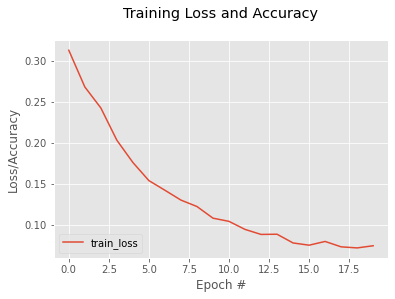

In [160]:
plot_model_loss(H, "loss_plot_model_1.png")

In [161]:
def plot_weights_mode(modelll, path):
    fig, axs = plt.subplots(1,2,constrained_layout=True)
    fig.suptitle('Weights matrix encoder/decoder', fontsize=16)
    fig.subplots_adjust(hspace =0.7)
    pcm = axs[0].imshow(modelll.get_weights()[0], interpolation='nearest', cmap=cm.Greys_r)
    axs[0].set_title("Encoder")
    axs[0].set_ylabel("Visible Node #")
    axs[0].set_xlabel("Hidden Node #")

    pcm=axs[1].imshow(modelll.get_weights()[0], interpolation='nearest', cmap=cm.Greys_r)
    axs[1].set_title("Decoder")
    axs[1].set_ylabel("Visible Node #")
    axs[1].set_xlabel("Hidden Node #")
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(pcm, cax=cbar_ax)
    plt.savefig(path)
    plt.show()

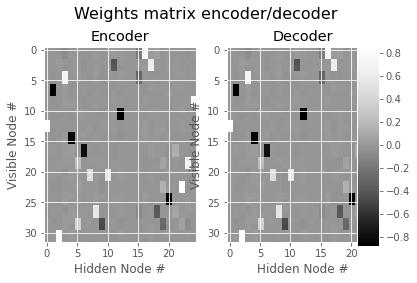

In [7]:
plot_weights_mode(model, "weights_plot_model_1.png")

In [162]:
def split_model_into_encoder_decoder(model, show_summary = False):
    layer_to_split = model.layers[0]
    index_to_split = 0
    for i in range(len(model.layers)):
        if model.layers[i].output.shape[-1] <= layer_to_split.output.shape[-1]:
            layer_to_split = model.layers[i]
            index_to_split = i 
    index_to_split +=1
    encoder = tf.keras.Model(
        inputs = model.input, 
        outputs = [layer.output for layer in model.layers[:index_to_split]]
        )

    decoder_input = Input(encoder.layers[-1].output_shape[-1])
    x = decoder_input
    for layer in model.layers[index_to_split:]:
        x = layer(x)
    decoder = tf.keras.Model(inputs = decoder_input, outputs = x) 
    if show_summary:
        print("------------------------ ENCODER ------------------------")
        encoder.summary()
        print("\n------------------------ DECODER ------------------------")
        decoder.summary()
    return encoder, decoder

In [163]:
encoder, decoder = split_model_into_encoder_decoder(model, show_summary = False)

In [164]:
# apply one bit flip in the latent space
def code_flip_decode(array, encoder, decoder, debuge_variation = False):
    N = np.shape(array)[-1]
    new_array = encoder(tf.expand_dims(array,0))[-1].numpy().flatten() #encode a sample 
    #new_array_binary = np.where(new_array>0, 1, 0) # binarize latent representation 
    index = np.random.randint(np.shape(new_array)[-1]) #choose random index to flip 
    new_array_fliped = copy.copy(new_array) # create copy of the encoded array 
    new_array_fliped[index] = 1-new_array_fliped[index] # apply flip  
    changed_tensor = tf.convert_to_tensor(tf.expand_dims(new_array_fliped,0)) #create new tensor 
    new_tensor = decoder(changed_tensor) # decode the sample with the change from the latent spaece
    output_array = new_tensor.numpy()[-1] # extraxt simple 1D array from tensor 
    output_array_binary = np.where(new_tensor.numpy()[-1]>0.5, 1, 0) # binarize decoded tensor around 0.5
    new_fitness = ut.hiff_fitness(output_array_binary) # calculate transformed tensor fitness
    output_tensor = tf.convert_to_tensor(output_array_binary.reshape((1,N)), dtype = tf.float32) # save output tensor
    if debuge_variation:
        print("Input fitness: ", ut.hiff_fitness(array), ", Decoded fitness: ", ut.hiff_fitness(output_array_binary))
        print("Input: ", array)
        print("Encoded: ", new_array)
        print("Encoded fliped, index: ", index, " : ", new_array_fliped)
        print("Decoded: ", output_array)
        print("Decoder binary: ", output_array_binary, "\n")
    return output_tensor, output_array_binary, new_fitness

In [165]:
# transfer a sample throught the encoder - decoder making random flips in the latent space 
def transfer_sample_latent_flip(array, encoder, decoder):
    N = np.shape(array)[-1]
    current_fitness = ut.hiff_fitness(array)
    for i in range(10 *N):
        output_tensor, output_array, new_fitness = code_flip_decode(array, encoder, decoder)
        if new_fitness >= current_fitness: # compare flip with current  fitness 
            current_fitness = new_fitness
            array = output_array
    return array

In [166]:
# generate training set based on the transfer_sample_latent_flip method, which enhance quality of the samples
def generate_new_training_set(initial_training_set, encoder, decoder):
    
    new_trainig_set = []
    N = np.shape(initial_training_set)[-1]
    normalization_factor = ut.hiff_fitness(np.ones((N,)))

    for array in initial_training_set:
        new_trainig_set.append(transfer_sample_latent_flip(array, encoder, decoder))
    return np.asarray(new_trainig_set, dtype = np.float32)

In [167]:
trainY2 = generate_new_training_set(trainY, encoder, decoder) # generate enhanced training set2

In [272]:
model2 = shallowNet.build() # build model2 based on the enhanced data set: trainY2
H2 = model2.fit(
    trainY2, trainY2, 
    epochs = epochs, 
    batch_size = batch_size,
    verbose = 1,
    shuffle = True
)

Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 25)                825       
_________________________________________________________________
dense_transpose_59 (DenseTra (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2575
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1839
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 0.1209
Epoch 4/20
20/20 [===

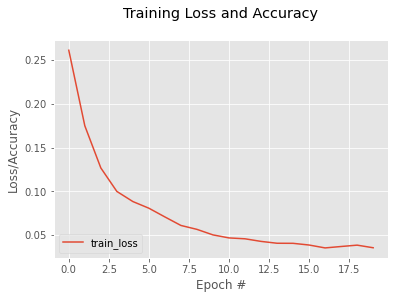

In [23]:
plot_model_loss(H2, "loss_plot_model_2.png")


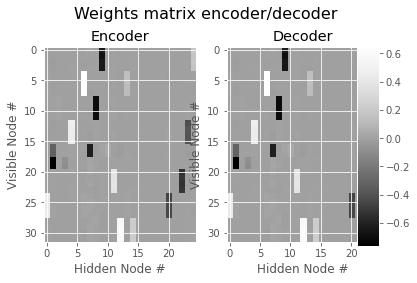

In [24]:
plot_weights_mode(model2, "weights_plot_model_2.png")

In [169]:
def generate_evolution_plot(encoder, decoder, array, path = "solution_development_model_2.png", learning_steps = 50):
    N = np.shape(array)[-1] # size of the array 
    index = np.random.randint(N) #choose random index to flip 
    candidate_solution = array[index]# pick up random sample 
    sol_evol = [] # list to store steps of evolution 
    sol_evol.append(candidate_solution)
    current_fittnes = ut.hiff_fitness(candidate_solution)
    print(candidate_solution)
    for i in range(learning_steps-1):
        new_candidate_sol = copy.copy(candidate_solution)
        output_tensor, output_array, new_fitness = code_flip_decode(new_candidate_sol, encoder, decoder)
        if new_fitness >= current_fittnes:
            candidate_solution = output_array 
            current_fittnes = new_fitness
        sol_evol.append(candidate_solution)

    tmp = np.array(sol_evol)
    plt.figure()
    plt.imshow(tmp, interpolation='nearest', cmap=cm.Greys_r)
    plt.title("Solution Development at Evolution Step 1")
    plt.xlabel("Solution variable")
    plt.ylabel("Development Step")
    plt.colorbar()
   # plt.savefig(path)
    plt.show()


[0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1.]


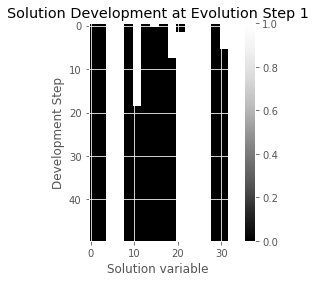

In [170]:
generate_evolution_plot(encoder, decoder, trainY)

In [171]:

def generate_trajectory_plot(encoder, decoder, array, target_size = 10, learning_steps = 30,):    
    normalization_factor = ut.hiff_fitness(np.ones((np.shape(array)[-1],)))
    trajectory_samples = []
    modified_data_set = np.ndarray(shape=(target_size,np.shape(array)[-1]))
    for k in range(target_size):
        current_array = array[k]
        current_fitness = ut.hiff_fitness(current_array)
        current_target_trajectory = []
        current_target_trajectory.append(current_fitness/normalization_factor)
        for i in range(learning_steps-1):
            output_tensor, output_array, new_fitness = code_flip_decode(current_array, encoder, decoder)
            if new_fitness >= current_fitness:
                current_fitness = new_fitness
                current_array = output_array
                current_target_trajectory.append(new_fitness/normalization_factor)
            else:
                current_target_trajectory.append(current_target_trajectory[-1])
            
        modified_data_set[k] = current_array
        trajectory_samples.append(current_target_trajectory)
    return modified_data_set, np.asarray(trajectory_samples)
    

In [172]:
def generate_trajectory_global_plot(encoder, decoder, array, epochs = 20, 
                                    learning_steps = 50, target_size = 10 ,
                                    path = "trajectory_model_2.png", debuge_variation = False, threshold = 5):

    loop_done = False
    fitness_history = [] 
    iteration = 0 
    while iteration <= epochs and not loop_done:
        array, trajectory_samples = generate_trajectory_plot(
                                        encoder=encoder, decoder = decoder,
                                        array = array,
                                        learning_steps = learning_steps, 
                                        target_size = target_size)
        fitness_history.append(trajectory_samples[:,-1])
        
        if debuge_variation:
            print(trajectory_samples[:,-1], " at iteration: ", iteration)

        if iteration > threshold and (fitness_history[-threshold] ==fitness_history[-1]).all():
           loop_done = True
           print("[INFO]: Loop was terminated after: ", iteration, " iterations, due to the lack of improvement!!!")

        iteration += 1
        

    plt.figure()
    plt.title("History Solution Trajectory after "+ str(epochs)+ " Epochs | epoch = " + str(learning_steps))
    fitness_history = np.asarray(fitness_history)
    X = np.arange(iteration)
    for i in range(iteration+1):
        plt.plot(X, fitness_history[:,i])
    plt.xlabel("epoch")
    plt.ylabel("fitness \ max_fitness")
    plt.show()
    return trajectory_samples
    


[0.65  0.75  0.75  0.75  0.7   0.8   0.625 0.675 0.85  1.   ]  at iteration:  0
[0.65  0.75  0.75  0.75  0.7   0.8   0.625 0.7   0.85  1.   ]  at iteration:  1
[0.65 0.75 0.75 0.75 0.7  0.8  0.7  0.7  0.85 1.  ]  at iteration:  2
[0.65 0.75 0.75 0.75 0.7  0.8  0.7  0.7  0.85 1.  ]  at iteration:  3
[0.65 0.75 0.75 0.75 0.7  0.8  0.7  0.7  0.85 1.  ]  at iteration:  4
[0.65 0.75 0.75 0.75 0.7  0.8  0.7  0.7  0.85 1.  ]  at iteration:  5
[0.65 0.75 0.75 0.75 0.7  0.8  0.7  0.7  0.85 1.  ]  at iteration:  6
[INFO]: Loop was terminated after:  6  iterations, due to the lack of improvement!!!


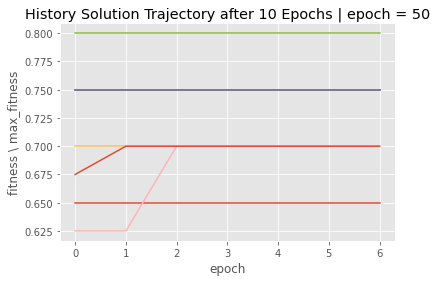

In [173]:
tmp = generate_trajectory_global_plot(encoder, decoder, trainY, debuge_variation=True, epochs = 10)

In [273]:
def add_layer_to_model(model, compression = 0.8, dropout = 0.2, reg_cof = 0.001, show_summary = False):
    """
    To do: 
     - add activation parameter
     - add stddev param
     - add initializer param 
    Add new layer to the middle of the model.

    Parameters:
        model - model to which we would like to add new layer 

    Optional parameters:
        compression (default 0.8) - level of compression compared to the latent space of the model 
        droupout (default 0.2) - dropout of the drop layer before new latent layer 
        reg_cof (default 0.001) - reguralization coefficient for new latent space 
        show_summary (default False) - variable to show new model structure
    """
    encoder_old, decoder_old = split_model_into_encoder_decoder(model) #split the old model into encoder and decoder
    latent_size = encoder_old.layers[-1].output.shape[-1] # calculate new latent size 
    input_shape =  model.input_shape[-1] # extract input shape 
    inputs = Input(shape=(input_shape,)) # explicitly define input layer 

    new_latent_layer = Dense( # new latent layer 
        int(latent_size * compression),activation="tanh",
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Zeros(),kernel_regularizer=tf.keras.regularizers.l1(reg_cof))
    new_decoding_layer = DenseTranspose(dense = new_latent_layer) # create dependant "diverging" layer

    x = encoder_old.layers[1](inputs) # add first layers: input -> encoder.layers[1]
    for e in encoder_old.layers[2:]: # add model encoder
        x = e(x)

    x = new_latent_layer(x) # add latent laver 
    x = new_decoding_layer(x) # add transition "diverging" layer
    for d in decoder_old.layers[1:]: # add model decoder
        x = d(x)

    new_model = tf.keras.Model(inputs, x) # construct model 
    opt = Adam(lr=0.01) # set up optimizer
    new_model.compile(loss='mse', optimizer=opt) # compile model 
    if show_summary:
        new_model.summary()
    return new_model

In [276]:
tmoModel = add_layer_to_model(model2, show_summary=True)

Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 25)                825       
_________________________________________________________________
dense_136 (Dense)            (None, 20)                520       
_________________________________________________________________
dense_transpose_61 (DenseTra (None, 25)                545       
_________________________________________________________________
dense_transpose_59 (DenseTra (None, 32)                857       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
________________________________________________________